In [1]:
from pandas import read_csv
from altair import *


In [26]:
data = Data(
    format=DataFormat(
        type='csv',
    ),
    file='./results_allfreq.csv',
)
data.values


undefined

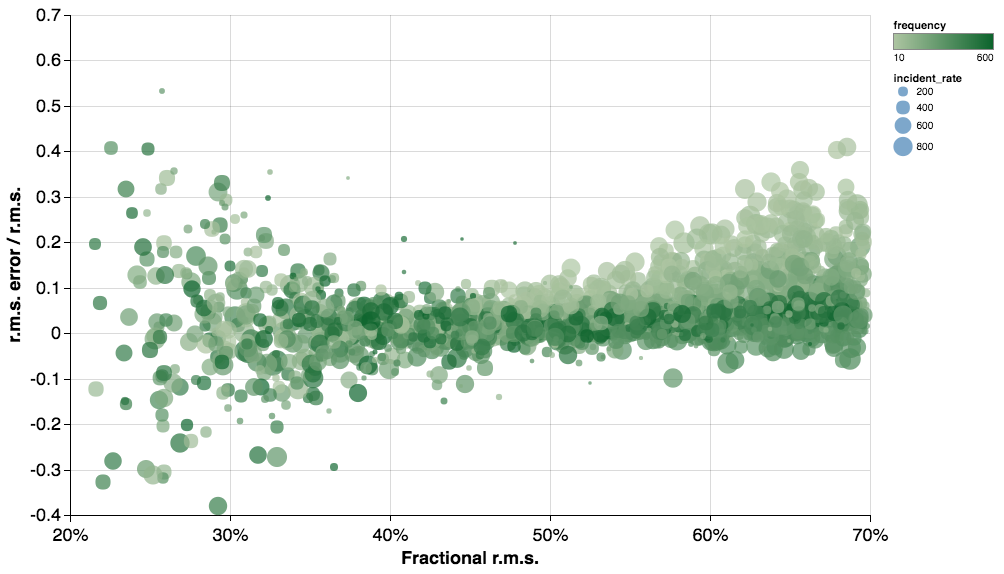

In [72]:
data = read_csv('results_allfreq.csv')
# data['frequency'] = data['frequency'] / 1000

rms_range = [0.2, 0.7]
cs_range = [-0.4, 0.6]
data = data[data['Frac_rms'].between(*rms_range, inclusive=True)]
data = data[data['CS'].between(*cs_range, inclusive=True)]

chart = Chart(data.dropna(),
              description='Blabla',
).mark_circle().encode(
    size=Size('incident_rate:Q'),
    x=X('Frac_rms:Q', scale=Scale(domain=rms_range),
        axis=Axis(titleFontSize=18, format='%', 
                  tickLabelFontSize=18, title='Fractional r.m.s.')
    ),
    y=Y('CS:Q', scale=Scale(domain=cs_range),
        axis=Axis(titleFontSize=18, format='.1', 
                  tickLabelFontSize=18, title='r.m.s. error / r.m.s.')
    ),
    color=Color('frequency:Q')
).configure_cell(
    height=500.0,
    width=800.0,
)
# chart.data.CS.contents
chart

In [35]:
from copy import deepcopy
import numpy as np
import pandas as pd
import altair


def linear_regression(x, y):
    """Return the linear regression of x & y evaluated at x"""
    p = np.polyfit(x, y, 1)
    return np.polyval(p, x)


class RegressionChart(altair.Chart):
    @staticmethod
    def _add_regression_column(group, regression_func, x, y, yfit):
        group[yfit] = regression_func(group[x], group[y])
        return group

    def regression_plot(self, func=linear_regression):
        if not isinstance(self.data, pd.DataFrame):
            raise ValueError("data must be a DataFrame")

        # we need a points layer and a lines layer
        points = self.mark_point()
        lines = deepcopy(self).mark_line()

        # confirm that none of the encodings are binned
        encoding = points.encoding.to_dict()
        if any(enc.get('bin', False) for enc in encoding.values()):
            raise ValueError("regress() cannot handle binned variables")

        # find variables that define groups
        group_cols = [enc['field'] for key, enc in encoding.items()
                      if key not in ['x', 'y']]
        x = encoding['x']['field']
        y = encoding['y']['field']
        yfit = y + '_fit'
        lines.encode(y=yfit)

        # perform the regression within each group
        if group_cols:
            groups = self.data.groupby(group_cols)
            data = groups.apply(self._add_regression_column,
                                regression_func=func,
                                x=x, y=y, yfit=yfit)
        else:
            data = self._add_regression_column(self.data.copy(),
                                               regression_func=func,
                                               x='x', y='y', yfit='y_fit')

        return altair.LayeredChart(data).set_layers(points, lines)

In [6]:
RegressionChart(data).encode(
    x='x',
    y='y',
    color='group:N',
).regression_plot()

KeyError: 'group'

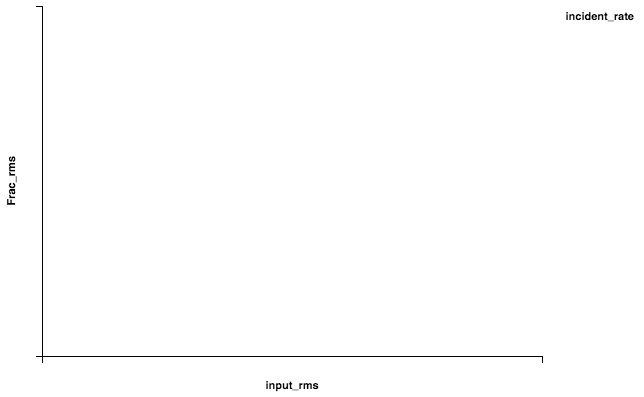

In [12]:
from altair import *

Chart(Data(
    format=DataFormat(
        type='csv',
    ),
    url='results_allfreq.csv',
),
    description='Blabla',
).mark_line().encode(
    color='incident_rate:N',
    x='input_rms:T',
    y='Frac_rms:Q',
)

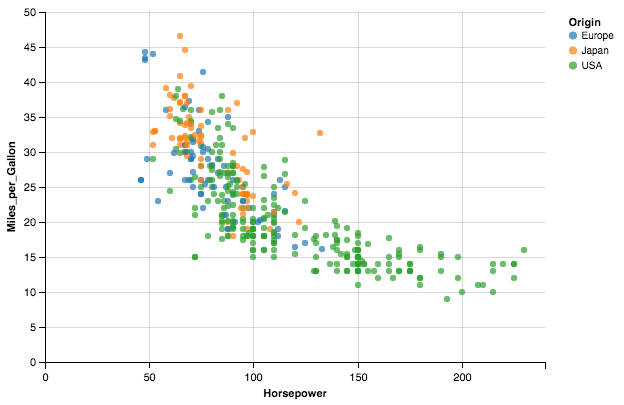

In [33]:
import altair as alt
data = alt.load_dataset('cars')

chart = alt.Chart(data).mark_circle().encode(
    x='Horsepower',
    y='Miles_per_Gallon',
    color='Origin',
)

chart